\newpage

# 0 Setup {-}

In [8]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    import tensorflow as tf

if IN_COLAB:
    %tensorflow_version 1.13
else:
    assert tf.__version__ == "1.13.1"

# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [9]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [10]:
print(tf.__version__)

1.13.1


In [11]:
# ignore tensorflow depreciation warnings
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

### 0.1 Visualizing the Dataset {-}

In [12]:
# given by the assignment
def loadData():
    with np.load("notMNIST.npz") as data:
        Data, Target = data ["images"], data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx]/255.
        Target = Target[randIndx]
        trainData, trainTarget = Data[:15000], Target[:15000]
        validData, validTarget = Data[15000:16000], Target[15000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

\newpage

In [13]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
print(f"Training Data: {trainData.shape}\tTraining tagets: {trainTarget.shape}")
print(f"Validation Data: {validData.shape}\tValidation tagets: {validTarget.shape}")
print(f"Testing Data: {testData.shape}\tTesting tagets:{testTarget.shape}")

Training Data: (15000, 28, 28)	Training tagets: (15000,)
Validation Data: (1000, 28, 28)	Validation tagets: (1000,)
Testing Data: (2724, 28, 28)	Testing tagets:(2724,)


In [14]:
def plot(image, target, ax=None):
    ax = plt.gca() if ax == None else ax
    ax.imshow(image, cmap=plt.cm.gray)
    target_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
    ax.set_title(target_names[target])
    # targets interger encoded from 0 to 9 corresponding to 'A' to 'J', respectively

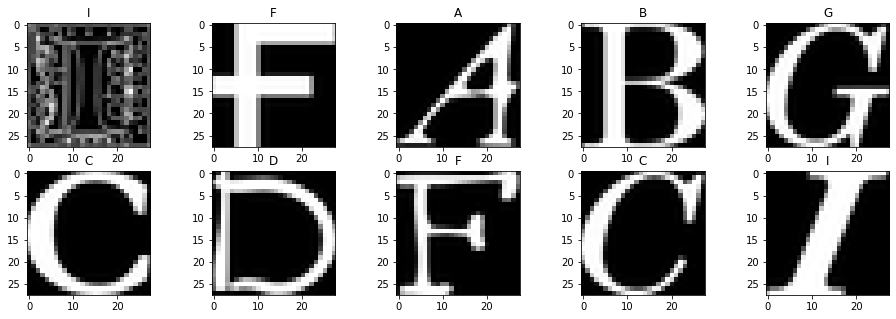

In [15]:
fig, axis = plt.subplots(2, 5, figsize=(16, 5))
for ax in axis.reshape(-1):
    r = np.random.randint(trainData.shape[0])
    plot(trainData[r], trainTarget[r], ax=ax)
plt.show()

\newpage

### 0.2 Useful Functions {-}

Some useful functions that will be used throughout the assignment such as getting random weights, getting the accuracy of a batch, making the loss and accuracy plots look nice, and global variables used throughout the code

In [16]:
# given by the assignment
def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))
    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest

In [17]:
def accuracy(y_pred, y):
    if y_pred.shape != y.shape:
        raise ValueError(f"prediction dimension {y_pred.shape} and label dimensions {y.shape} don't match")
    return np.sum(y_pred.argmax(axis=1) == y.argmax(axis=1)) / y.shape[0]

In [18]:
def plot_loss(x, train_loss=None, valid_loss=None, test_loss=None, title=None, ax=None):
    ax = plt.gca() if ax == None else ax
    if train_loss != None:
        ax.plot(x, train_loss, label="Training Loss")
    if valid_loss != None:
        ax.plot(x, valid_loss, label="Validation Loss")
    if test_loss != None:
        ax.plot(x, test_loss, label="Testing Loss")
    
    ax.set_title("Loss" if title == None else title)
    
    ax.set_xlabel("Iterations")
    ax.set_xlim(left=0)
    ax.set_ylabel("Loss")
    ax.set_ylim(bottom=0)
    ax.legend(loc="upper right")

def plot_accuracy(x, train_accuracy=None, valid_accuracy=None, test_accuracy=None, title=None, ax=None):
    ax = plt.gca() if ax == None else ax
    if train_accuracy != None:
        ax.plot(x, train_accuracy, label="Training Accuracy")
    if valid_accuracy != None:
        ax.plot(x, valid_accuracy, label="Validation Accuracy")
    if test_accuracy != None:
        ax.plot(x, test_accuracy, label="Testing Accuracy")
    
    ax.set_title("Accuracy" if title == None else title)

    ax.set_xlabel("Iterations")
    ax.set_xlim(left=0)
    ax.set_ylabel("Accuracy")
    ax.set_yticks(np.arange(0, 1.1, step=0.1))
    ax.grid(linestyle='-', axis='y')
    ax.legend(loc="lower right")
    

def display_statistics(train_loss=None, train_acc=None, valid_loss=None, valid_acc=None, 
                       test_loss=None, test_acc=None, num=True, plot=True):
    
    tl = "-" if train_loss is None else round(train_loss[-1], 4)
    ta = "-" if train_acc is None else round(train_acc[-1]*100, 2)
    vl = "-\t" if valid_loss is None else round(valid_loss[-1], 4)
    va = "-" if valid_acc is None else round(valid_acc[-1]*100, 2)
    sl = "-\t\t" if test_loss is None else round(test_loss[-1], 4)
    sa = "-" if test_acc is None else round(test_acc[-1]*100, 2)
    
    if num:
        print(f"Training loss: {tl}{'':.20s}\t\tTraining acc: {ta}{'%' if ta != '-' else ''}")
        print(f"Validation loss: {vl}{'':.20s}\tValidation acc: {va}{'%' if va != '-' else ''}")
        print(f"Testing loss: {sl}{'':.20s}\tTesting acc: {sa}{'%' if sa != '-' else ''}")
    
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(18, 6))
        plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
        plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
        plt.show()
        plt.close()

In [19]:
TINY = 1e-20
newtrain, newvalid, newtest = convertOneHot(trainTarget, validTarget, testTarget)
VTDatasets = {"validData" : validData.reshape(validData.shape[0], -1), "validTarget" : newvalid,
              "testData" : testData.reshape(testData.shape[0], -1), "testTarget" : newtest}

N = trainData.shape[0]
d = trainData.shape[1] * trainData.shape[2]
K = 10

\newpage

# 1 Neural Networks using Numpy {-}
### 1.1 Helper Functions {-}

In [20]:
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    return np.exp(x) / np.exp(x).sum()

def softmax_batch(X):
    return np.exp(X) / np.exp(X).sum(axis=1, keepdims=True)

In [21]:
def computeLayer(X, W, b):
    # TODO: Remove this comment when finished
    #  W might need to get transposed depending on how we define it
    return X @ W.T + b

In [22]:
# target is one-hot encoded
def CE(target, prediction):
    return -(target * np.log(prediction+TINY)).sum(axis=1).mean()

# Including this because handout requires a helper function with this signature
# TODO: rename our CE function everywhere to averageCE to match with handout
def averageCE(target, prediction):
    return CE(target, prediction)

# target is one-hot encoded
def gradCE(target, predication):
    return predication - target

### 1.2 Backpropagation Derivation {-} 

#### Derivative of Softmax

$p_i = \texttt{softmax}(\textbf{o})_i = \frac{e^{o_i}}{\sum_{k=1}^K e^{o_k}}$

$\quad \quad \quad \text{if  } i \neq j$
$$\frac{\partial p_j}{\partial o_i} = \frac{0 \cdot \sum_{k=1}^K e^{o_k} - e^{o_i} \cdot e^{o_j}}{\left(\sum_{k=1}^K e^{o_k}\right)^2} = \boxed{- p_i \cdot p_j}$$

$\quad \quad \quad \text{if  } i = j$
$$\frac{\partial p_j}{\partial o_i} = \frac{e^{o_i} \cdot \sum_{k=1}^K e^{o_k} - e^{o_i} \cdot e^{o_j}}{\left(\sum_{k=1}^K e^{o_k}\right)^2} = \boxed{(1 - p_j) \cdot p_i}$$

#### Derivative of Softmax + Cross Entropy Loss

$L_{CE}(\textbf{y}, \textbf{p}) = -\sum_{k=1}^{K} y_k \log{p_k}$

$$ \frac{\partial L_{CE}}{\partial o_i} =  -\sum_{k=1}^{K} \frac{y_k}{p_k} \cdot \frac{\partial p_k}{\partial o_i} = -y_i(1 - p_i) - \sum_{k \neq i} \frac{y_k}{p_k} \cdot (-p_k p_i) = -y_i + y_ip_i + \sum_{k \neq i} y_k p_i = -y_i + p_i \cdot \sum_{k=1}^K y_k = p_i - y_i$$

In Vector Form: $\boxed{\frac{\partial L_{CE}}{\partial \textbf{o}} = \textbf{p} - \textbf{y}}$

#### Remaining Backpropogation

$\textbf{o} = W_o \textbf{g} + \textbf{b}_o$

$$\frac{\partial L}{\partial W_o} = \frac{\partial L}{\partial \textbf{o}} \cdot \left(\frac{\partial \textbf{o}}{\partial W_o}\right)^T = \frac{\partial L}{\partial \textbf{o}} \cdot \textbf{g}^T$$

$$\frac{\partial L}{\partial \textbf{b}_o} = \frac{\partial L}{\partial \textbf{o}} \cdot \left(\frac{\partial \textbf{o}}{\partial \textbf{b}_o}\right)^T = \frac{\partial L}{\partial \textbf{o}}$$

$g_i = \texttt{ReLU}(h_i) = \texttt{max}(h_i, 0)$

$$\frac{\partial L}{\partial h_i} = \frac{\partial L}{\partial g_i} \cdot \frac{\partial g_i}{\partial h_i} = \begin{cases} \frac{\partial L}{\partial g_i} &\text{if } h_i > 0 \\ 0 &\text{if } h_i < 0 \end{cases}$$

$\textbf{h} = W_h \textbf{x} + \textbf{b}_h$

$$\frac{\partial L}{\partial W_h} = \frac{\partial L}{\partial \textbf{h}} \cdot \left(\frac{\partial \textbf{h}}{\partial W_h}\right)^T = \frac{\partial L}{\partial \textbf{h}} \cdot \textbf{x}^T$$

$$\frac{\partial L}{\partial \textbf{b}_h} = \frac{\partial L}{\partial \textbf{h}} \cdot \left(\frac{\partial \textbf{h}}{\partial \textbf{b}_h}\right)^T = \frac{\partial L}{\partial \textbf{h}}$$

### 1.3 Learning {-}

epoch: 1
epoch: 2	loss: 41.4530	acc: 0.0727
epoch: 3	loss: 37.2774	acc: 0.3967
epoch: 4	loss: 29.8780	acc: 0.5609
epoch: 5	loss: 21.5857	acc: 0.6715
epoch: 6	loss: 16.0508	acc: 0.8008
epoch: 7	loss: 14.0872	acc: 0.7896
epoch: 8	loss: 12.6737	acc: 0.7926
epoch: 9	loss: 9.6796	acc: 0.8383
epoch: 10	loss: 11.3654	acc: 0.7863
epoch: 11	loss: 8.7359	acc: 0.8430
epoch: 12	loss: 7.8002	acc: 0.8585
epoch: 13	loss: 9.7367	acc: 0.8201
epoch: 14	loss: 8.0913	acc: 0.8541
epoch: 15	loss: 7.5170	acc: 0.8613
epoch: 16	loss: 7.4273	acc: 0.8669
epoch: 17	loss: 9.0573	acc: 0.8222
epoch: 18	loss: 7.3267	acc: 0.8591
epoch: 19	loss: 7.3108	acc: 0.8588
epoch: 20	loss: 7.5515	acc: 0.8621
epoch: 21	loss: 8.5821	acc: 0.8500
epoch: 22	loss: 8.2129	acc: 0.8586
epoch: 23	loss: 7.4454	acc: 0.8760
epoch: 24	loss: 7.3893	acc: 0.8774
epoch: 25	loss: 8.1171	acc: 0.8666
epoch: 26	loss: 8.8314	acc: 0.8579
epoch: 27	loss: 8.5914	acc: 0.8666
epoch: 28	loss: 8.4644	acc: 0.8710
epoch: 29	loss: 8.3776	acc: 0.8771
epoch: 30	l

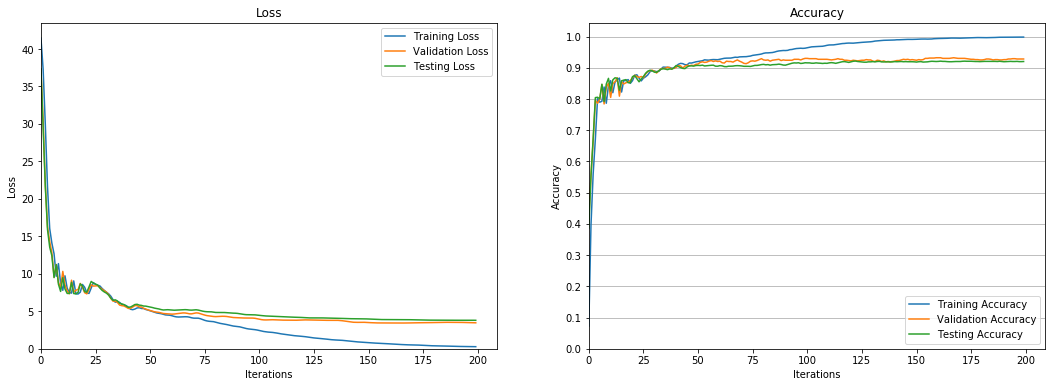

Time is 347.3596692085266.


In [29]:
class mini_NN(object):

    """ 
    Network Structure:
        input:  x
        hidden: h = W_h * x + b_h
                g = ReLU(h)
        output: o = W_o * g + b_o
                p = softmax(o)
    """

    def __init__(self, D, F, K):
        # D, F, and K are the number of neurons in the input, hidden, and output layers
        self.D = D
        self.F = F
        self.K = K
        self.init_weights()

    def init_weights(self):
        # getting random parameters using Xaiver initialization scheme
        self.W_h = np.random.normal(0, np.sqrt(2.0/(self.D+self.F)), (self.F, self.D))
        self.b_h = np.random.normal(0, np.sqrt(2.0/(self.D+self.F)), self.F) 
        self.W_o = np.random.normal(0, np.sqrt(2.0/(self.F+self.K)), (self.K, self.F))
        self.b_o = np.random.normal(0, np.sqrt(2.0/(self.F+self.K)), self.K)
    
    def feedforward(self, X):
        # python can dynamically create attributes
        self.H = computeLayer(X, self.W_h, self.b_h)
        self.G = relu(self.H)
        self.O = computeLayer(self.G, self.W_o, self.b_o)
        self.P = softmax_batch(self.O)
        return self.P
    
    def backpropagation(self, X, y):
        
        # This function assumes that feedforward was called before, 
        # which instantiates the needed activations
        
        # output layer activations
        dL_do = gradCE(y, self.P)

        # output layer parameters
        dL_dWo = dL_do.T @ self.G
        dL_dbo = dL_do

        # hidden layer activations
        dL_dg = dL_do @ self.W_o 
        dL_dh = dL_dg.copy()
        dL_dh[self.H <= 0] = 0

        # hidden layer parameters
        dL_dWh = dL_dh.T @ X
        dL_dbh = dL_dh
        
        return dL_dWo , dL_dbo.sum(axis=0), dL_dWh, dL_dbh.sum(axis=0)
        #return dL_dWo/X.shape[0] , dL_dbo.mean(axis=0), dL_dWh/X.shape[0], dL_dbh.mean(axis=0)

    def train(self, X, y, epochs=200, gamma=0.99, alpha=1e-5, F=None,
              validData=None, validTarget=None, testData=None, testTarget=None):
        # initializations
        self.F = self.F if F is None else F
        self.init_weights()
        
        train_loss, train_acc = [], []
        valid_loss, valid_acc = [], []
        test_loss, test_acc = [], []
        
        v_Wo, v_Wh = 0, 0
        
        for e in range(epochs):
            if e > 0:
                print(f"epoch: {e+1}\tloss: {train_loss[-1]:.4f}\tacc: {train_acc[-1]:.4f}")
            else:
                print("epoch:", e+1)
            
            # getting predictions
            p = self.feedforward(X)
            train_loss.append( CE(p, y) )
            train_acc.append( accuracy(p, y) )
            
            # getting gradients
            dL_dWo, dL_dbo, dL_dWh, dL_dbh = self.backpropagation(X, y)
            
            # updating parameters
            v_Wo = gamma * v_Wo + alpha * dL_dWo
            self.W_o -= v_Wo
            
            self.b_o -= alpha * dL_dbo
            
            v_Wh = gamma * v_Wh + alpha * dL_dWh
            self.W_h -= v_Wh
            
            self.b_h -= alpha * dL_dbh
            
            # calculating statistics
            if not validData is None and not validTarget is None:
                p = self.feedforward(validData)
                valid_loss.append(CE(p, validTarget))
                valid_acc.append(accuracy(p, validTarget))
            if not testData is None and not testTarget is None:
                p = self.feedforward(testData)
                test_loss.append(CE(p, testTarget))
                test_acc.append(accuracy(p, testTarget))
        
        statistics = (train_loss, train_acc)
        if not validData is None and not validTarget is None:
            statistics += (valid_loss, valid_acc, )
        if not testData is None and not testTarget is None:
            statistics += (test_loss, test_acc,)
        return statistics

X = trainData.reshape(N, d)

y = newtrain

# For investigation, analyze how long each hyperparameter set takes to train
import time
start = time.time()

model = mini_NN(d, 1000, K)
# TODO: remove this comment
#P = model.feedforward(X)
#print(P)
#print(P.argmax(axis=1))
statistics = model.train(X, y, epochs=200, gamma=0.99, alpha=1e-5, **VTDatasets)
display_statistics(*statistics)
print(f"Time is {time.time() - start}.")

### 1.4 Hyperparameter Investigation {-}

## Number of Hidden Units

### Number of hidden units: 100

|Statistic | Value | | Statistic | Value |
|:---|---:|---|:---|---:|
| Training loss:| 4.6824	|	|Training acc:|92.31%|
| Validation loss:| 5.5578	 |   |Validation acc:|89.8%|
| Testing loss:| 5.7423	 |  |Testing acc:|89.46%|
| Training Time(s):| 42.705

**Comments**: Accuracy seems to have converged by 50 iterations. Training this network with 100 hidden units was the fastest of the three. This is likely because there were very few parameters to optimize.

### Number of hidden units: 500

Statistic | Value | | Statistic | Value 
:---|---:|---|:---|---:
Training loss: |0.7009	|	|Training acc: |99.36%
Validation loss: |3.894	  |  |Validation acc: |91.9%
Testing loss: |4.1808	  |  |Testing acc: |91.19%
Training Time(s): |176.361

**Comments**: Accuracy seems to have converged by 50 iterations. Training this network with 500 hidden units was slower than with 100 units, but the validation/testing accuracies showed slight improvement. Further, Training loss and training accuracy near perfection. Since this trend is not matched by validation/testing accuracies, we see that the network is overfitting as it is learning the training examples too well.

### Number of hidden units: 2000

Statistic | Value | | Statistic | Value 
:---|---:|---|:---|---:
Training loss: |0.2303	||	Training acc: |99.82%
Validation loss:| 3.3766||	    Validation acc: |93.0%
Testing loss: |3.8814	 ||   Testing acc: |91.85%
Training Time(s): |645.494

**Comments**: Accuracy seems to have convered by 50 iterations. Training this network with 2000 hidden units was considerably slower than both other networks, depite nearly identical validation/testing accuracies. Training loss and training accuracy are essentially perfect by the end of 200 epochs. Since this trend is not matched by validation/testing accuracies, we see that the network is overfitting considerably. It has essentially memorized the training examples, but can not generalize as well (beyond the performance attained by smaller networks) to validation/testing data.

**General comments**: Also, the small bump and incresae in loss before once again decreasing suggest that the parameters went through a local minimum before converging. Momentum likely helped it converge faster as it doesn't appear to have gotten stuck in the local min. The smaller networks trained considerably faster, but had lower accuracy (even though the difference was very small). The larger networks clearly overfit the training data; this indicates that they are too complex for their classification tasks and/or the input data should be improved.

## Early Stopping
From the plots, we observe that training should have stopped at an early stopping point of 50 iterations. Beyond this point, there is very little improvement in either validation/testing losses or accuracies.

\newpage

# 2 Neural Networks in Tensorflow {-}
### 2.1 Model implementation {-}

In [30]:
# load + reshape data
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
trainData = trainData.reshape(15000,28,28,1)
validData = validData.reshape(1000,28,28,1)
testData = testData.reshape(2724,28,28,1)

# one-hot encode
train_labels, valid_labels, test_labels = convertOneHot(trainTarget, validTarget, testTarget)

# training params
learning_rate = 0.0001
epochs = 50
batch_size = 32

# create model
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(28, 28,1)))                            # input layer
model.add(layers.Conv2D(                                                        # conv layer
        filters=32,
        strides=(1,1),
        kernel_size=[3, 3],
        padding="same",
        activation='relu',
        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False)))
model.add(layers.BatchNormalization())                                          # batch norm
model.add(layers.MaxPooling2D((2, 2)))                                          # max pooling
model.add(layers.Flatten())                                                     # flatten
model.add(layers.Dense(784, activation='relu'))                                 # fully-connected 784 w/ ReLu
model.add(layers.Dense(10))                                                     # fully-connected 10
model.add(layers.Softmax())                                                     # softmax output

# TODO: remove this comment
# print model summary
# model.summary()

# compile model w/ Adam optimizer + cross entropy loss
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



### 2.2 Model Training {-}

In [31]:
# callback to test after each epoch
class TestCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_acc = []
        self.test_loss = []

    def on_epoch_end(self, epoch, logs=None):
        # perform a test per epoch
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0, batch_size=32)
        self.test_loss.append(loss)
        self.test_acc.append(acc)
        # append to returned dictionary
        logs["test_loss"] = self.test_loss
        logs["test_acc"] = self.test_acc


# train
history = model.fit(trainData, train_labels, 
                    validation_data=(validData, valid_labels),
                    epochs=epochs, 
                    batch_size=batch_size,
                    callbacks=[TestCallback((testData, test_labels))],
                    verbose=0,  # 0 = silent, 1 = per epoch 
                    shuffle=True)

# print(history.history)

# plot accuracy + loss
train_acc = history.history["acc"]
val_acc = history.history["val_acc"]
test_acc = history.history["test_acc"][0]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
test_loss = history.history["test_loss"][0]

statistics = (train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc)
display_statistics(*statistics)

InvalidArgumentError: logits and labels must have the same first dimension, got logits shape [32,10] and labels shape [320]
	 [[{{node loss/softmax_loss/CategoricalCrossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]

### 2.3 Hyperparameter Investigation {-}

In [16]:
# 2.3.1: L2 Regularization

# training params
learning_rate = 0.0001
epochs = 50
batch_size = 32

# test all weight decays [0.01, 0.1, 0.5]
for scale in [0.01, 0.1, 0.5]:
    print("\nL2 Normalization with {}\n".format(scale))

    # create model
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(28, 28,1)))    # input layer
    model.add(layers.Conv2D(                                                        # conv layer
          filters=32,
          strides=(1,1),
          kernel_size=[3, 3],
          padding="same",
          activation='relu',
          kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False)))
    model.add(layers.BatchNormalization())                                          # batch norm
    model.add(layers.MaxPooling2D((2, 2)))                                          # max pooling
    model.add(layers.Flatten())                                                     # flatten
    model.add(layers.Dense(784, 
                        activation='relu',
                        kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=scale)))  # fully-connected 784 w/ ReLu
    model.add(layers.Dense(10))                                                     # fully-connected 10
    model.add(layers.Softmax())                                                     # softmax output

    # compile model w/ Adam optimizer + cross entropy loss
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    # train
    history_1 = model.fit(trainData, train_labels, 
                      validation_data = (validData, valid_labels),
                      epochs=epochs, 
                      batch_size=batch_size,
                      callbacks=[TestCallback((testData, test_labels))],
                      verbose=0,  # 0 = silent, 1 = per epoch 
                      shuffle=True)
    # display stats
    train_acc = history_1.history["acc"]
    val_acc = history_1.history["val_acc"]
    test_acc = history_1.history["test_acc"][0]
    train_loss = history_1.history["loss"]
    val_loss = history_1.history["val_loss"]
    test_loss = history_1.history["test_loss"][0]

    statistics = (train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc)
    display_statistics(*statistics)


L2 Normalization with 0.01

Training loss: 1.5333		Training acc: 97.11%
Validation loss: 1.5669		Validation acc: 93.7%
Testing loss: 1.5711		Testing acc: 93.14%

L2 Normalization with 0.1

Training loss: 1.6085		Training acc: 92.58%
Validation loss: 1.6073		Validation acc: 92.9%
Testing loss: 1.6118		Testing acc: 92.11%

L2 Normalization with 0.5

Training loss: 1.6735		Training acc: 90.23%
Validation loss: 1.669		Validation acc: 89.5%
Testing loss: 1.6639		Testing acc: 90.79%


In [19]:
# 2.3.2: Dropout

# training params
learning_rate = 0.0001
epochs = 50
batch_size = 32

# for rate in [0.9, 0.75, 0.5]:
for rate in [0.1, 0.25, 0.5]:
    print("\nDropout with probability {}\n".format(rate))

    # create model
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(28, 28,1)))    # input layer
    model.add(layers.Conv2D(                                                        # conv layer
          filters=32,
          strides=(1,1),
          kernel_size=[3, 3],
          padding="same",
          activation='relu',
          kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False)))
    model.add(layers.BatchNormalization())                                          # batch norm
    model.add(layers.MaxPooling2D((2, 2)))                                          # max pooling
    model.add(layers.Flatten())                                                     # flatten
    model.add(layers.Dense(784))                                                    # fully-connected 784 w/ ReLu
    model.add(layers.Dropout(rate=rate))                                            # dropout
    model.add(layers.ReLU())                                                         # Relu activation
    model.add(layers.Dense(10))                                                     # fully-connected 10
    model.add(layers.Softmax())                                                     # softmax output

    # compile model w/ Adam optimizer + cross entropy loss
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    # train
    history_2 = model.fit(trainData, train_labels, 
                      validation_data = (validData, valid_labels),
                      epochs=epochs, 
                      batch_size=batch_size,
                      callbacks=[TestCallback((testData, test_labels))],
                      verbose=0,  # 0 = silent, 1 = per epoch 
                      shuffle=True)
    # display stats
    train_acc = history_2.history["acc"]
    val_acc = history_2.history["val_acc"]
    test_acc = history_2.history["test_acc"][0]
    train_loss = history_2.history["loss"]
    val_loss = history_2.history["val_loss"]
    test_loss = history_2.history["test_loss"][0]

    statistics = (train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc)
    display_statistics(*statistics)


Dropout with probability 0.1

Training loss: 1.4825		Training acc: 97.86%
Validation loss: 1.5235		Validation acc: 93.7%
Testing loss: 1.529		Testing acc: 93.14%

Dropout with probability 0.25

Training loss: 1.479		Training acc: 98.21%
Validation loss: 1.524		Validation acc: 93.6%
Testing loss: 1.5286		Testing acc: 93.14%

Dropout with probability 0.5

Training loss: 1.4801		Training acc: 98.13%
Validation loss: 1.5189		Validation acc: 94.3%
Testing loss: 1.5255		Testing acc: 93.54%
